# Описание проекта: телекоммуникации

Оператор связи __«Ниединогоразрыва.ком»__ хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. *digital subscriber line*) или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Данные находятся в директории `/datasets/final_provider/`.

#### Список уточняющих вопросов:

Вопросов нет

#### План работы:

Улучшить удержание клиентов и снизить отток.

Задача: Разработать модель бинарной классификации, которая будет предсказывать, уйдет ли клиент или останется с компанией на основе доступных признаков. 
Решается задача бинарной классификации.

**План**
<a id='plan'></a>
1. [x] Проверка и подготовка данных :  
    - [x] Поиск ошибков, пропусков
    - [x] Оценка статистик численных значений
    - [x] Сравнение датафреймов на пересечение индексов
    - [x] Создание общего датафрейма. Определение категориальных полей
    - [x] Заполнение пропусков в обобщенной таблице
2. [x] Исследовательский анализ
    - [x] Исследовать зависимости признаков от целевого признака
    - [x] Проверка сбалансированности классов
3. [x] Построение и обучение моделей
    - [x] Построить, обучить с использованием кросс-валидации несколько моделей
    - [x] Оценить результаты в рамках требований
4. [x] Вывод по результатам

# Импорт библиотек. Глобальные переменные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import phik
import math

# обучение
from sklearn.metrics import (auc, roc_curve, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, confusion_matrix)
from sklearn.model_selection import (train_test_split, cross_val_predict,
                                     GridSearchCV, RandomizedSearchCV)


from sklearn.ensemble import RandomForestClassifier 
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

import shap

from tqdm import tqdm
from sklearn.base import clone
import copy
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
PARSE_DATE='2020-02-01'

In [3]:
RANDOM_STATE = 3072023 #np.random.RandomState(3072023)
RAND_STATE = 3072023

Загрузим и изучим данные

In [4]:
try:
    d_contract = pd.read_csv('C:/0/d/f/contract_new.csv')
    d_internet  = pd.read_csv('C:/0/d/f/internet_new.csv')
    d_personal = pd.read_csv('C:/0/d/f/personal_new.csv')
    d_phone    = pd.read_csv('C:/0/d/f/phone_new.csv')
    print('Прочитали данные с диска')
except:
    d_contract = pd.read_csv('/datasets/contract_new.csv')
    d_internet = pd.read_csv('/datasets/internet_new.csv')
    d_personal = pd.read_csv('/datasets/personal_new.csv')
    d_phone    = pd.read_csv('/datasets/phone_new.csv')
    print('Прочитали данные в сети')

Прочитали данные с диска


In [5]:
# создадим список названий датафреймов
d_list = ['contract','internet','personal','phone']

# EDA и предобработка

## Посмотрим информацию по датафреймам

### Датафрейм d_contract

In [6]:
d_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
d_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Изменим тип данных поля TotalCharges с object на float64

In [8]:
d_contract['TotalCharges'] = pd.to_numeric(d_contract['TotalCharges'], errors='coerce').fillna(0)

In [9]:
d_contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


Посмотрим как доли уникальных значений по всем полям

In [10]:
d_contract['EndDate'].value_counts(normalize=True)

EndDate
No            0.843675
2020-01-01    0.005537
2019-12-01    0.005395
2018-11-01    0.004969
2019-09-01    0.004544
                ...   
2014-09-01    0.000284
2014-12-01    0.000284
2014-06-01    0.000142
2014-10-01    0.000142
2014-11-01    0.000142
Name: proportion, Length: 67, dtype: float64

In [11]:
d_contract['Type'].value_counts(normalize=True)

Type
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: proportion, dtype: float64

In [12]:
d_contract['PaperlessBilling'].value_counts(normalize=True)

PaperlessBilling
Yes    0.592219
No     0.407781
Name: proportion, dtype: float64

In [13]:
d_contract['PaymentMethod'].value_counts(normalize=True)

PaymentMethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: proportion, dtype: float64

In [14]:
# Посмотрим дубликаты
d_contract.duplicated().sum()

0

In [15]:
def check_uniq_customers(df):
    ununiq_cnt =  d_contract.shape[0]-d_contract['customerID'].nunique()
    if ununiq_cnt>0:
        print('Некоторые клиенты в таблице встречаются более одного раза')
        print('Количество записей с одинаковыми клиентами:',ununiq_cnt)
    else: print('Все клиенты в таблице встречаются не более одного раза')
    return

In [16]:
check_uniq_customers(d_contract)

Все клиенты в таблице встречаются не более одного раза


#### Первые EDA выводы. Датафрейм d_contract:
- не содержит пропусков
- не содержит дубликатов
- все клиенты встречаются в таблице d_contract не более одного раза
- содержит поле EndDate, которое будет использовано для создания поля с целевым бинарным значением. Видим, что классы не сбалансированны (доля незаконченных договоров составляет 84,3675%)
- поле 'MonthlyCharges':
    - среднее значение  (64.76) немного ниже медианы (70.35), что может указывать на легкое смещение распределения влево
    - (это может указывать на то, что цена играет важную роль при выборе услуг. Некоторые клиенты могут активно искать более низкие стоимости, сравнивать предложения и выбирать наиболее экономичные варианты (это подтверждается также большой долей клиентов с помесячной системой оплаты). Это может быть связано с особенностями рынка, конкуренцией или потребностями клиентов с ограниченными ресурсами. Также смещение распределения влево может указывать на преобладание клиентов с низкими месячными платежами. Возможно, компания имеет более широкую базу клиентов с меньшими расходами, что может быть стратегическим выбором или следствием характеристик предоставляемых услуг).
    - Также можно отметить наличие выбросов, так как максимальное значение (118.75) значительно отличается от третьего квартиля (89.85).
- поле 'TotalCharges':
    - среднее значение (2115.31) выше медианы (1343.35), что может указывать на смещение распределения вправо (некоторые клиенты могут выбирать более дорогие пакеты услуг, дополнительные сервисы или иметь длительные периоды использования услуг, что приводит к значительно более высоким затратам)


### Датафрейм d_internet

In [17]:
d_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [18]:
d_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [19]:
"""
функция, которая принимает датафрейм и список его категориальных полей и возвращает
датафрейм category_distributions с долями категорий:
"""
def calculate_category_distributions(dataframe, categorical_fields):
    category_distributions = pd.DataFrame()

    for field in categorical_fields:
        field_distribution = dataframe[field].value_counts(normalize=True)
        field_distribution.name = field
        category_distributions = pd.concat([category_distributions, field_distribution], axis=1)
        
    category_distributions = category_distributions.transpose()
    category_distributions.columns.name = 'Category'
    
    return category_distributions

In [20]:
# Получение долей категорий в каждом столбце
calculate_category_distributions(d_internet, ['OnlineSecurity', 'OnlineBackup',
                                             'DeviceProtection', 'TechSupport',
                                             'StreamingTV', 'StreamingMovies','InternetService'])

Category,No,Yes,Fiber optic,DSL
OnlineSecurity,0.634040,0.365960,NaN,NaN
OnlineBackup,0.559724,0.440276,NaN,NaN
DeviceProtection,0.560993,0.439007,NaN,NaN
TechSupport,0.629509,0.370491,NaN,NaN
StreamingTV,0.509335,0.490665,NaN,NaN
StreamingMovies,0.504803,0.495197,NaN,NaN
InternetService,NaN,NaN,0.561175,0.438825


In [21]:
check_uniq_customers(d_internet)

Все клиенты в таблице встречаются не более одного раза


#### Первые EDA выводы. Датафрейм d_internet:
- пропусков нет
- все клиенты встречаются в таблице d_internet не более одного раза (дубликатов нет)
- все поля каегориальные и имеют по два значения
- значения во всех полях распределены примерно поровну

### Датафрейм d_personal

In [22]:
d_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [23]:
d_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [24]:
# Получение долей категорий в каждом столбце
calculate_category_distributions(d_personal, ['gender', 'SeniorCitizen',
                                             'Partner', 'Dependents'])

Category,Male,Female,0,1,No,Yes
gender,0.504756,0.495244,NaN,NaN,NaN,NaN
SeniorCitizen,NaN,NaN,0.837853,0.162147,NaN,NaN
Partner,NaN,NaN,NaN,NaN,0.516967,0.483033
Dependents,NaN,NaN,NaN,NaN,0.700412,0.299588


In [25]:
check_uniq_customers(d_personal)

Все клиенты в таблице встречаются не более одного раза


#### Первые EDA выводы. Датафрейм d_personal:
- пропусков нет
- все клиенты в таблице встречаются не более одного раза (дубликатов нет)
- все поля каегориальные и имеют по два значения
- значения во всех полях gender и Partner распределены примерно поровну, в полях SeniorCitizen и Dependents с преобладанием нулевого класса

### Датафрейм d_phone

In [26]:
d_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [27]:
d_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [28]:
# Получение долей категорий в каждом столбце
calculate_category_distributions(d_phone, ['MultipleLines'])

Category,No,Yes
MultipleLines,0.532935,0.467065


In [29]:
check_uniq_customers(d_phone)

Все клиенты в таблице встречаются не более одного раза


#### Первые EDA выводы. Датафрейм d_phone:
- пропусков нет
- все клиенты в таблице встречаются не более одного раза (дубликатов нет)
- все поля каегориальные и имеют по два значения
- значения в поле  распределены MultipleLines примерно поровну.

## Сравним и объединим таблицы

Посмотрим совпадения / расхождения по полю customerID

In [30]:
# Общий список клиентов
all_customer_ids = pd.concat([
    d_contract['customerID'],d_internet['customerID'],
    d_personal['customerID'],d_phone['customerID']
]).unique().tolist()

In [31]:
print('Количество уникальных customerID, в объединенном списке: ',len(all_customer_ids))
print()
print('Таблица - Количество уникальных customerID, которого не хвадает до объединенного списка:')
for d in d_list:
    l = len(list(set(all_customer_ids)-set(eval('d_'+d+'["customerID"]'))))
    print('d_'+d,' - ',l)

Количество уникальных customerID, в объединенном списке:  7043

Таблица - Количество уникальных customerID, которого не хвадает до объединенного списка:
d_contract  -  0
d_internet  -  1526
d_personal  -  0
d_phone  -  682


Видим, что уникальные значения поля customerID в таблицах d_contract, d_personal в точности совпадают между собой и с общим (объединенным) списком.

Около 10% клиентов не пользуются телефоном и около 15% не пользуются интернетом. Также, очевидно, что основная часть клиентов пользуется и телефоном и интернетом

Соответственно, при объединении таблиц мы получим пустые значения для части клиентов в полях для интернет и телефонной таблиц

In [32]:
# установим в качестве индекса значения поля customerID
for d in d_list:
    eval('d_' + d).set_index('customerID', inplace=True)

In [33]:
# объединим таблицы
df = pd.concat([eval('d_' + item) for item in d_list], axis=1)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null 

Обработаем категориальные признаки.
- Поля таблиц d_contact: `['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']` и d_personal: `['gender', 'SeniorCitizen', 'Partner', 'Dependents']` не имеют пропусков
- поля таблиц d_internet `['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies']` и d_phone `['MultipleLines']` имеют бинарные значения. Пропуски в них заменим на `'N_A'`

In [35]:
# создадим список категориальных полей
cat_features = (['Type', 'PaymentMethod', 'PaperlessBilling'] + 
    list(d_personal.columns) + 
    list(d_internet.columns) + 
    list(d_phone.columns))

In [36]:
# заменим пропуски на 'N_A'
for feild in cat_features: df[feild] = df[feild].fillna('N_A')

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Замена пропущенных значений в полях с категориальными значениями на новое значение 'N_A' вместо 'No' может быть обоснована следующими причинами:

Отдельное значение для пропущенных данных: Иногда пропущенные значения могут иметь свою собственную семантику и не являться просто отсутствием значения. В данном случае, использование значения 'N_A' может указывать на отсутствие данных или недоступность информации, что отличается от значения 'No', которое обычно используется для указания явного отрицания или отсутствия.

Предотвращение искажений в анализе: Замена пропущенных значений категориальных переменных на конкретное значение, такое как 'No', может внести искажения в анализ данных и моделирование. Это связано с тем, что пропуски могут иметь свою собственную структуру или неслучайный характер, и присвоение им конкретного значения может исказить распределение данных и влиять на результаты анализа.

Лучшая интерпретируемость результатов: Использование отдельного значения, такого как 'N_A', помогает явно отличать пропущенные значения от других категорий, таких как 'Yes' и 'No'. Это может быть полезно при интерпретации результатов анализа или моделирования, поскольку исключает неопределенность, связанную с неприсутствующими данными.
   </font>
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> 
У нас есть информация обо всех услугах, которыми пользуется клиент, и мы можем проследить, какие конкретно услуги у него подключены или не подключены. Поэтому использование значения 'No' для пропущенных значений может неправильно указывать на отсутствие подключенного пакета услуг, когда на самом деле у клиента может быть подключен другой пакет или он вообще не пользуется услугами.

Замена пропусков на новое значение 'N_A' позволяет нам явно указать, что для данных клиентов нет доступных данных о пакете услуг или конкретных услугах. Таким образом, мы сохраняем информацию о пропущенных данных и отличаем их от случаев, когда клиент не подключен к конкретному пакету услуг.
   </font>
</div>

In [37]:
df[cat_features].head()

,Type,PaymentMethod,PaperlessBilling,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Electronic check,Yes,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,N_A
5575-GNVDE,One year,Mailed check,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Mailed check,Yes,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,Bank transfer (automatic),No,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,N_A
9237-HQITU,Month-to-month,Electronic check,Yes,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Разберемся с датами

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Проверим даты в поле `EndDate`. Мы будем использовать данное поле для вычисления меток целевого значения. Принцип определения меток: если у клиента нет даты окончания договора, его можно считать неушедшим. Это можно сделать на данном этапе, создав поле `churn`, но мы пока не знаем как пересекаются множества значений полей `customerID` в разных таблицах. Поэтому логично будет значения `No` заменить на значения даты среза базы данных PARSE_DATE = 2020-02-01. Но предварительно надо проверить есть ли в таблице клиенты, которые ушли в эту дату, поскольку, ориентируясь на 2020-02-01 как на признак неушедших клиентов, мы можем ошибочно к ним отнести фактически ушедших.
   </font>
</div>

In [38]:
# последняя дата для "ушедших" клиентов
df.loc[d_contract['EndDate'] != 'No', 'EndDate'].max()

'2020-01-01'

In [39]:
PARSE_DATE

'2020-02-01'

In [40]:
df[df['EndDate']==PARSE_DATE]['EndDate'].count()

0

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Видим, что клиентов, ушедших в `PARSE_DATE` нет. Таким образом замена `No` на `PARSE_DATE` законна.
   </font>
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b></b></u></font>
    <br />
    <font color='4682B4'> Перед заменой 'EndDate' на `PARSE_DATE` используем значение `No` для определения меток в поле целевого значения.
   </font>
</div>

In [41]:
# создадим столбец с целевой меткой
max_end_date = PARSE_DATE
df['churn'] = (df['EndDate'] != 'No').astype(int)
df['churn'].value_counts(normalize=True)

churn
0    0.843675
1    0.156325
Name: proportion, dtype: float64

In [42]:
# Обработка значений "No" в поле EndDate
df.loc[df['EndDate'] == 'No', 'EndDate'] = PARSE_DATE

In [43]:
# Изменение типа на datetime
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

Общая доля ушедших клиентов - 15,6%

Оценим дискретность значений в столбцах df['EndDate'] и df['BeginDate'] - т.е. какие характерные даты там встречаются (только соответствующие началу месяца или также есть даты внутри месяца)

In [44]:
begin_dates = pd.to_datetime(df['BeginDate'])
end_dates = pd.to_datetime(df['EndDate'])

In [45]:
begin_dates_masked = begin_dates.dt.strftime('%Y.%m.%d').str.endswith('.01')
end_dates_masked = end_dates.dt.strftime('%Y.%m.%d').str.endswith('.01')

print('Количество дат в столбце BeginDate, соответствующих маске "yyyy.mm.01":')
print(len(begin_dates[begin_dates_masked]))
print('Даты в столбце BeginDate, не соответствующие маске "yyyy.mm.01":')
print(begin_dates[~begin_dates_masked])
print()
print('Количество дат в столбце EndDate, соответствующих маске "yyyy.mm.01":')
print(len(end_dates[end_dates_masked]))
print('Даты в столбце EndDate, не соответствующие маске "yyyy.mm.01":')
print(end_dates[~end_dates_masked])

Количество дат в столбце BeginDate, соответствующих маске "yyyy.mm.01":
7043
Даты в столбце BeginDate, не соответствующие маске "yyyy.mm.01":
Series([], Name: BeginDate, dtype: datetime64[ns])

Количество дат в столбце EndDate, соответствующих маске "yyyy.mm.01":
7043
Даты в столбце EndDate, не соответствующие маске "yyyy.mm.01":
Series([], Name: EndDate, dtype: datetime64[ns])


Видим, что все даты соответствуют маске yyyy.mm.01. Будем считать длительность действия договора в днях

In [46]:
df['Duration'] = (df['EndDate'] - df['BeginDate']).dt.days

Теперь создадим список полей с численными значениями

In [47]:
num_features = ['Duration','MonthlyCharges','TotalCharges']

## Исследование данных

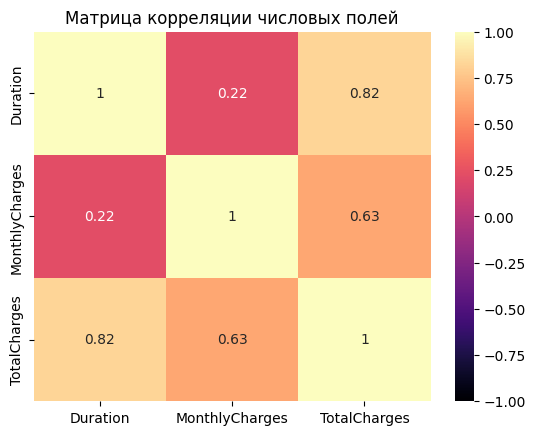

In [48]:
sns.heatmap(df[num_features].corr(),annot=True, cmap='magma', vmin=-1, vmax=1)
plt.title('Матрица корреляции числовых полей')
plt.show()

Видим, что общие затраты имеуют условно высокий уровень прямой зависимости от времени жизни контракта. И чуть менее слабую прямую зависимость от ежемесячных платежей. Эти зависимости очевидны.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   InternetService   7043 non-null   object        
 8   OnlineSecurity    7043 non-null   object        
 9   OnlineBackup      7043 non-null   object        
 10  DeviceProtection  7043 non-null   object        
 11  TechSupport       7043 non-null   object        
 12  StreamingTV       7043 non-null   object        
 13  StreamingMovies   7043 non-null   object        
 14  gender        

In [50]:
# Вычисляем матрицу корреляции Фи-коэффициента
corr_matrix = df.phik_matrix(interval_cols=num_features)

print(corr_matrix)

                  BeginDate   EndDate      Type  PaperlessBilling  \
BeginDate          1.000000  0.548313  0.766249          0.081447   
EndDate            0.548313  1.000000  0.285429          0.062936   
Type               0.766249  0.285429  1.000000          0.106860   
PaperlessBilling   0.081447  0.062936  0.106860          1.000000   
PaymentMethod      0.456389  0.169262  0.277462          0.370495   
MonthlyCharges     0.421886  0.173493  0.388444          0.467812   
TotalCharges       0.774207  0.217670  0.470860          0.201703   
InternetService    0.192197  0.117099  0.505187          0.231438   
OnlineSecurity     0.460712  0.166235  0.636884          0.208320   
OnlineBackup       0.496176  0.236373  0.581660          0.195321   
DeviceProtection   0.502422  0.225828  0.631531          0.195687   
TechSupport        0.455418  0.150303  0.671629          0.200621   
StreamingTV        0.419599  0.185980  0.549564          0.204717   
StreamingMovies    0.431137  0.199

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> После анализа матрицы корреляции Фи-коэффициента для категориальных признаков, можно сделать следующие выводы:

Категориальные признаки и их связь с оттоком (churn):
- Partner имеет наиболее сильную положительную корреляцию с оттоком (churn), что может указывать на то, что клиенты, не имеющие партнера, склонны больше уходить.
- PaymentMethod и InternetService также имеют некоторую положительную корреляцию с оттоком (churn), что может указывать на связь между выбранным методом оплаты или типом интернет-сервиса и решением клиента уйти.
        
Некоторые признаки имеют сильную положительную корреляцию:
- OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies имеют сильную положительную корреляцию между собой. Это может указывать на то, что клиенты, которые подписываются на одну из этих услуг, склонны подписываться и на другие связанные услуги.
- InternetService имеет сильную положительную корреляцию с OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies. Это может указывать на то, что клиенты, использующие определенный тип интернет-сервиса, чаще всего также подписываются на эти связанные услуги.

Некоторые признаки имеют сильную отрицательную корреляцию:
- Type и InternetService имеют сильную отрицательную корреляцию с gender. Это может указывать на то, что тип услуги или тип интернет-сервиса может быть связан с полом клиента.

Некоторые признаки имеют слабую корреляцию:
- Type, PaymentMethod и PaperlessBilling имеют слабую корреляцию с другими признаками. Это может указывать на то, что эти признаки могут быть независимыми и не сильно связаны с другими признаками.

   </font>
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Настраивание параметра interval_cols в функции phik_matrix() важно, потому что этот параметр позволяет указать столбцы с интервальными (числовыми) переменными в вашем наборе данных.

Матрица корреляции Фи-коэффициента (Phi correlation coefficient matrix) предназначена для измерения корреляции между переменными в наборе данных, включая как категориальные, так и числовые переменные. Однако, для правильного вычисления Фи-коэффициента, интервальные переменные (числовые) требуют предварительного группирования или бинирования.

Указание параметра interval_cols позволяет функции phik_matrix() знать, какие столбцы следует рассматривать как интервальные переменные и какие необходимо бинировать перед вычислением коэффициента Фи. Это важно, чтобы получить правильные значения корреляции между всеми переменными, включая числовые.

Таким образом, правильное указание interval_cols позволяет учесть числовые переменные в вычислении корреляции Фи и обеспечить корректный анализ зависимостей между всеми типами переменных в вашем наборе данных.

   </font>
</div>

In [51]:
# Вычисляем матрицу корреляции Фи-коэффициента
df_without_churn = df#.drop(columns=['churn'])
corr_matrix = df_without_churn.phik_matrix(interval_cols=num_features)

# Выводим матрицу только для значений коэффициентов >= 0.8
high_corr_matrix = corr_matrix[corr_matrix >= 0.8]


In [52]:
# Определяем строки и столбцы, содержащие значения отличные от NaN
rows_to_keep = []
cols_to_keep = []

# Проверяем диагональные элементы матрицы
for field in high_corr_matrix.index:
    # Проверяем значения в строке и столбце, исключая диагональные элементы
    row_values = high_corr_matrix.loc[field, :].drop(field)
    col_values = high_corr_matrix.loc[:, field].drop(field)
    if any(row_values.notnull()) or any(col_values.notnull()):
        rows_to_keep.append(field)
        cols_to_keep.append(field)

# Формируем итоговую отфильтрованную матрицу
filtered_matrix = high_corr_matrix.loc[rows_to_keep, cols_to_keep]
print(filtered_matrix)

                  BeginDate  EndDate  MonthlyCharges  TotalCharges  \
BeginDate          1.000000      NaN             NaN           NaN   
EndDate                 NaN      1.0             NaN           NaN   
MonthlyCharges          NaN      NaN        1.000000           NaN   
TotalCharges            NaN      NaN             NaN      1.000000   
InternetService         NaN      NaN        0.919002           NaN   
OnlineSecurity          NaN      NaN        0.812632           NaN   
OnlineBackup            NaN      NaN        0.818851           NaN   
DeviceProtection        NaN      NaN        0.827272           NaN   
TechSupport             NaN      NaN        0.816660           NaN   
StreamingTV             NaN      NaN        0.864677           NaN   
StreamingMovies         NaN      NaN        0.863616           NaN   
churn                   NaN      1.0             NaN           NaN   
Duration           0.978521      NaN             NaN      0.848337   

                  I

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Анализ матрицы Фи-корреляции:

  - Наблюдается понятная высокая положительная корреляция между переменными "BeginDate" и "Duration" (0.978521), а также между Churn и EndDate. Это потому что Churn и Duration сформированы на основе дат. Даты исключим из дальнейшего рассмотрения.

  - Переменные `"MonthlyCharges"` и поля из списка:  `["InternetService", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]`  имеют высокую положительную корреляцию. Это означает, что существует сильная связь между месячными платежами клиентов и интернет (тв) -услугой, которую они используют. Данный список исключим из дальнейшего рассмотрения.

  - `"TotalCharges"` имеет высокую положительную корреляцию с `"Duration"` - исключим `TotalCharges` из дальнейшего рассмотрения
   </font>
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА V.2</b></u></font>
    <br />
    <font color='4682B4'> Создам списки полей для исключения. Само исключение сделаю позже перед моделированием. Чтобы не исключать поля на этапе EDA (ниже)

   </font>
</div>

In [53]:
num_feat_drop = ["TotalCharges"]
cat_feat_drop = ["InternetService", "InternetService", "OnlineSecurity",
                 "OnlineBackup", "DeviceProtection", "TechSupport",
                 "StreamingTV", "StreamingMovies"]

### Посмотрим распределение данных

In [54]:
def stat_plot(data, legend, bins=50):
    fig, (ax_hist, ax_box_0, ax_box_1) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (1, 0.4, 0.4)})
    
    # Гистограмма
    ax_hist.hist(data, bins=bins, density=True, label=legend, stacked=True,
                 color=['lightgreen', 'red'], alpha=0.7, edgecolor='black', linewidth=0.5)
    ax_hist.legend()
    ax_hist.set_title('Histogram')
    ax_hist.set_ylabel('Density')
    
    # Ящик с усами (Churn = 0)
    boxprops_churn_0 = {'facecolor': 'lightgreen', 'alpha': 0.7}
    ax_box_0.boxplot(data[0], vert=False, labels=[legend[0]], patch_artist=True,
                     boxprops=boxprops_churn_0)
    ax_box_0.set_title('Boxplot')
    
    # Ящик с усами (Churn = 1)
    boxprops_churn_1 = {'facecolor': 'red', 'alpha': 0.7}
    ax_box_1.boxplot(data[1], vert=False, labels=[legend[1]], patch_artist=True,
                     boxprops=boxprops_churn_1)
    
    plt.xlabel('Value')
    plt.suptitle(data[0].name)
    plt.tight_layout()
    plt.show()

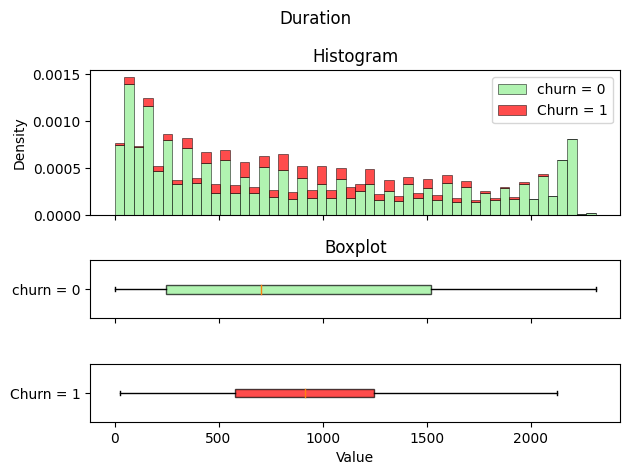

In [55]:
field = 'Duration'
stat_plot([df[df['churn'] == 0][field], df[df['churn'] == 1][field]],
          legend=['churn = 0', 'Churn = 1'], bins=50)

Видим, что клиенты уходят в основном "сразу"- в первые месяцы. При этом не ушедшие клиенты, также имеют пик в начальных сроках дюрации контрактов, но также есть заметная группа "постоянных" клиентов с высокими значениями дюрации. Также отметим, что межквартильный размах дюрации ушедших клиентов уже, чем у постоянных.

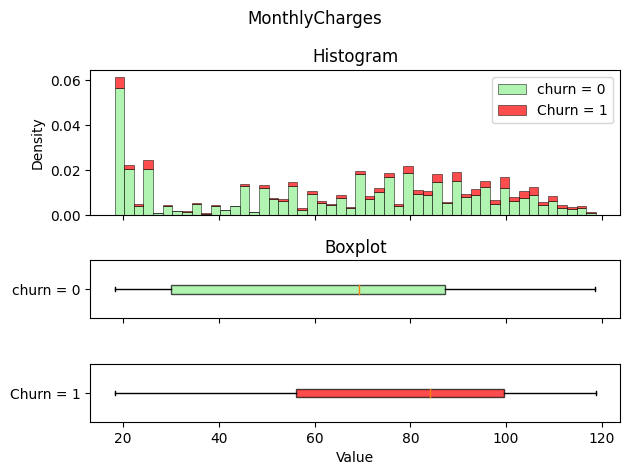

In [56]:
field = 'MonthlyCharges'
stat_plot([df[df['churn'] == 0][field], df[df['churn'] == 1][field]],
          legend=['churn = 0', 'Churn = 1'], bins=50)

Распределение ежемесячных платежей имеет заметный пик около нуля. Данная особенность предварительно была выявлена на начальном этапе: "это может указывать на то, что цена играет важную роль при выборе услуг. Некоторые клиенты могут активно искать более низкие стоимости, сравнивать предложения и выбирать наиболее экономичные варианты (это подтверждается также большой долей клиентов с помесячной системой оплаты".

Также отметим, что основная часть ушедших клиентов платила больше, чем неушедшие клиенты. Т.е. такие клиенты готовы платить больше, но они более осознанно подходят к выбору поставщика услуг и готовы его менять.

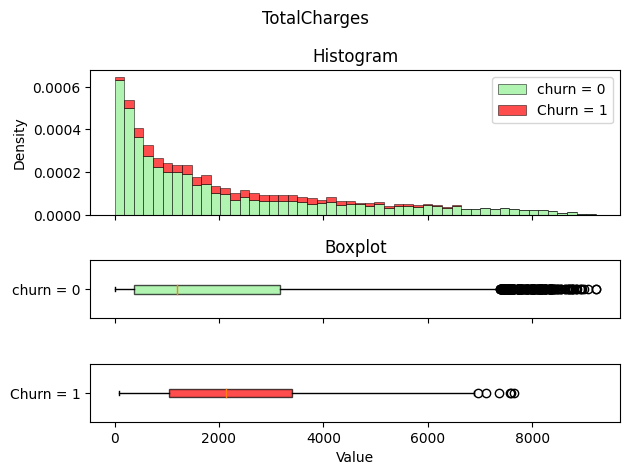

In [57]:
field = 'TotalCharges'
stat_plot([df[df['churn'] == 0][field], df[df['churn'] == 1][field]],
          legend=['churn = 0', 'Churn = 1'], bins=50)

Распределение общих затрат подтверждает выводы о том, что клиенты стремятся выбирать наиболее экономичные варианты, а также, что в портфеле компании - значительная часть новых клиентов, т.е. с низкими значениями дюрации контрактов. Т.е. можно говорить о постоянном пополнении клиентской базы.

Компания как теряет в значительной степени клиентов с низкими значениями дюрации контрактов, так и пополняет свою клиентскую базу новыми клиентами, ищущими низкие цены. Т.о. можно говорить, что значительная часть новых клиентов не задерживается в компании.

Посмотрим значения дюрации контрактов для разных категориальных признаков, по ушедшим / неушедшим клиентам

In [58]:
def plot_feat_impact(feature, category_feature):
    v_cnt = df[feature].value_counts()
    plt.figure(figsize=(12, 0.6 * len(v_cnt)))
    
    # Установка порядка категорий на графике
    if 'Yes' in v_cnt.index:
        c_ord = ['Yes', 'No']
        if 'N_A' in v_cnt.index:
            c_ord.append('N_A')
    else: c_ord = None
    
    # График средних значений без разделения по группам Churn
    sns.barplot(x=df[category_feature], y=df[feature].astype('str'),
                errcolor='lightgrey', color='lightgreen', order=c_ord)
    
    # График средних значений с разделением по группам Churn
    sns.barplot(x=df[category_feature], y=df[feature].astype('str'),
                hue=df['churn'], order=c_ord)
    
    plt.xlabel("")
    plt.show()

In [59]:
cat_features

['Type',
 'PaymentMethod',
 'PaperlessBilling',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

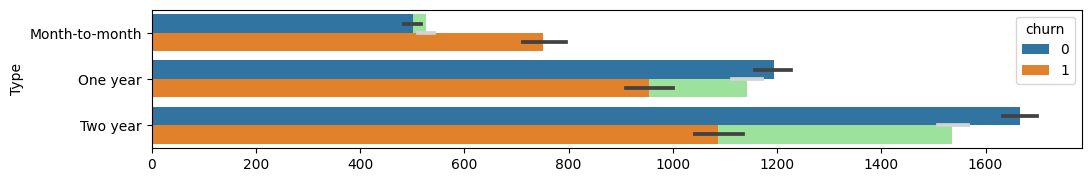

In [60]:
plot_feat_impact('Type', 'Duration')

Ушедших клиентов с помесячной оплатой заметно больше, че неушедших. Далее если клиент остается в компании, он скорее всего переходит на более длинные контракты

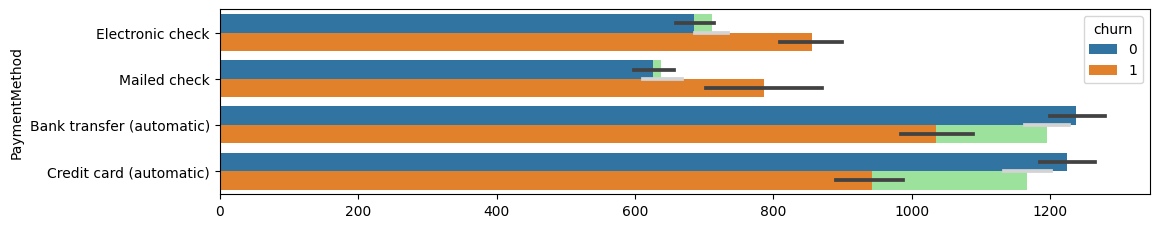

In [61]:
plot_feat_impact('PaymentMethod', 'Duration')

"Летуны" держат руку на пульсе с оплатами. Постоянные клиенты используют автоматическое списание средств.

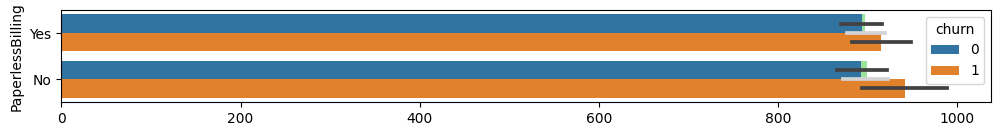

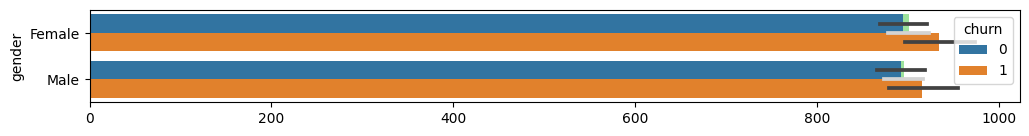

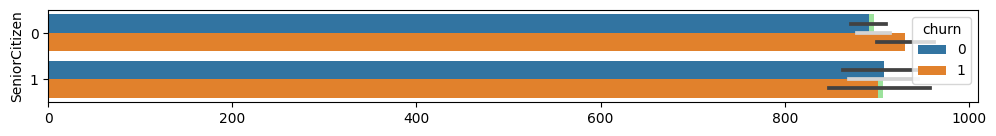

In [62]:
for f in ['PaperlessBilling','gender','SeniorCitizen']:
    plot_feat_impact(f, 'Duration')

Данная группа признаков сильно не влияет на дюрацию контрактов в разрезе ушедших/неушедших клиентов

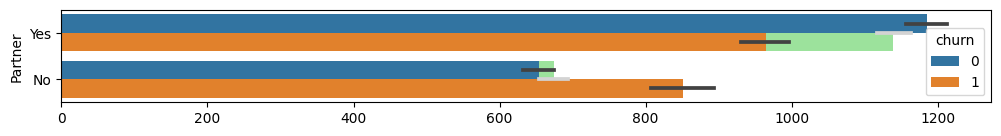

In [63]:
plot_feat_impact('Partner', 'Duration')

Наличие партнера заметно влияет на длитеность контрактов: в группе без партнера дюрация ушедших клиентов больше. В группе с партнером- наоборот.

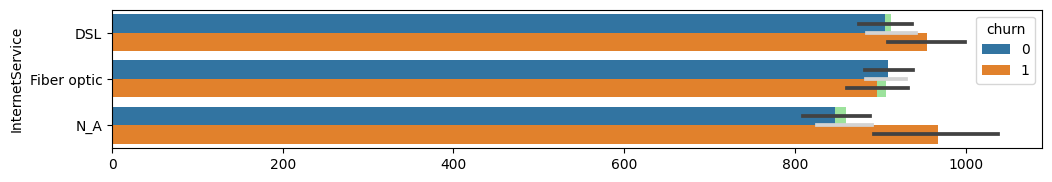

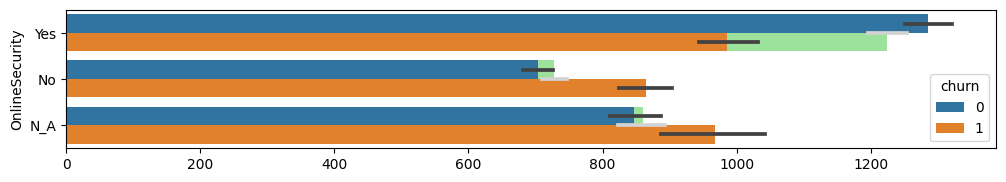

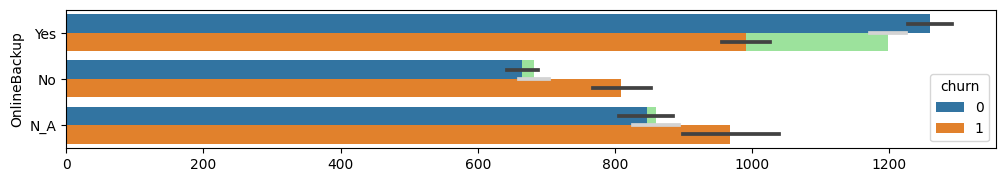

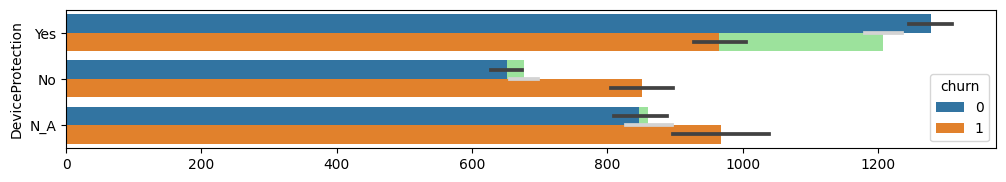

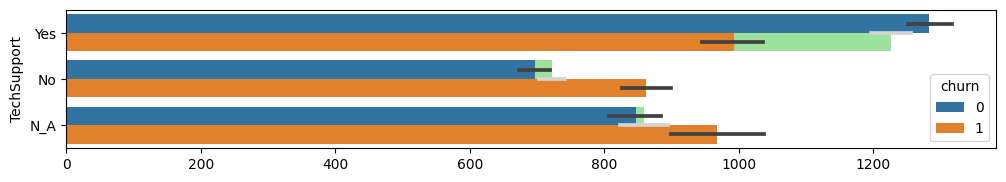

In [64]:
for f in ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',]:
    plot_feat_impact(f, 'Duration')

Можно отметить, что ушедшие клиенты без услуг связанных с интернетов имеют заметно бОльшую дюрацию контрактов, и наоборот в группах с такими услугами дюрация ушедших - меньше. Т.е. клиенты, которые не уходят сначала не пользуются сервисами, но, похоже, потом их приобретают.

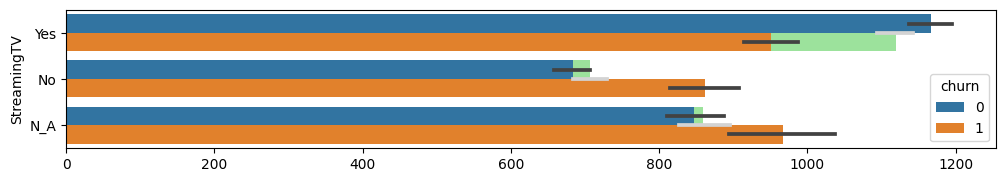

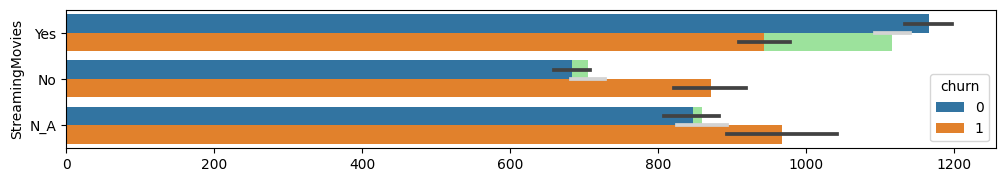

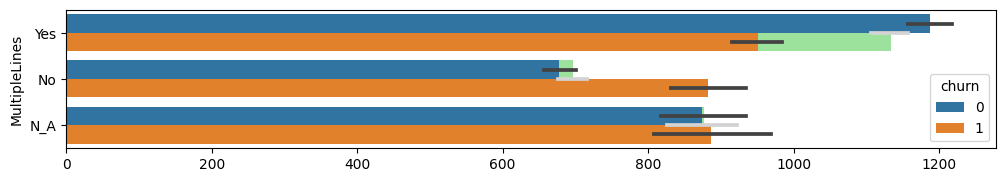

In [65]:
for f in ['StreamingTV','StreamingMovies','MultipleLines']:
    plot_feat_impact(f, 'Duration')

Аналогично - с услугами телефонии телевидения.

## EDA общие выводы:

После проведения предварительного анализа данных (EDA) для датафреймов d_contract, d_internet, d_personal и d_phone, мы получили следующие основные выводы:

- Общие выводы:
    - Данные не содержат пропусков, дубликатов и повторяющихся клиентов.
    - Классы целевого признака Churn (уход клиента) не сбалансированы, примерно 84.37% клиентов имеют незаконченные договоры (ушедшие клиенты).
    - Время пользования услугами влияет на решение клиента об уходе или остающемся. Большинство ушедших клиентов покидают компанию в первые месяцы.
    - Цена (ежемесячный платеж) играет важную роль при выборе услуг. Клиенты, выбирающие низкие стоимости и экономичные варианты, склонны менять провайдера.
    - Длительность контракта, тип оплаты и наличие партнера также влияют на решение клиента об уходе или остающемся.
    - Постоянные клиенты имеют более долгую длительность контракта и часто используют автоматическое списание средств.
    - Клиенты, подключающие дополнительные услуги (интернет, телефония, телевидение), склонны оставаться дольше.
    - Большая часть ушедших клиентов платила больше, чем клиенты, которые остаются.
    - Распределение ежемесячных платежей имеет пик около нуля, что указывает на высокую чувствительность клиентов к цене.

    - Компания сталкивается с вызовом удержания клиентов, особенно в первые месяцы пользования услугами.
    - Акцент на дополнительных услугах, сопутствующих основным (интернет, телефония, телевидение), может повысить лояльность клиентов и увеличить их длительность контракта.
    - Необходимо анализировать поведение клиентов с разными типами оплаты и разработать индивидуальные стратегии удержания для каждого типа.
    - Постоянное пополнение клиентской базы новыми клиентами является хорошей стратегией, но также необходимо обратить внимание на удержание текущих клиентов.
    - Необходимо провести дальнейший анализ и моделирование данных для более точного прогнозирования ухода клиентов и разработки персонализированных стратегий удержания.

Преобразование данных связанное с кодированием и масштабированием признаков будет включено в пайплайн модели машинного обучения и не включено в данный раздел.

# Обучение моделей

Получим train/test выборки в соотношении 3:1 

Выделим целевой признак

### Подготовка признаков

Удалю следующие столбцы:
- Даты `BeginDate` и `EndDate`, поскольку их наличие повлечет утечку при обучении
- `TotalCharges` - мультиколлинеарный по отношению к `Duration`

Преобразуем столбцы с категориями к типи _categotry_

In [67]:
df.drop(columns=(['BeginDate', 'EndDate']+num_feat_drop+cat_feat_drop), inplace=True)

In [68]:
# Удаление элементов
num_features = [feature for feature in num_features if feature not in num_feat_drop]
cat_features = [feature for feature in cat_features if feature not in cat_feat_drop]

In [69]:
df[cat_features] = df[cat_features].astype("category")

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   gender            7043 non-null   category
 5   SeniorCitizen     7043 non-null   category
 6   Partner           7043 non-null   category
 7   Dependents        7043 non-null   category
 8   MultipleLines     7043 non-null   category
 9   churn             7043 non-null   int32   
 10  Duration          7043 non-null   int64   
dtypes: category(8), float64(1), int32(1), int64(1)
memory usage: 506.7+ KB


In [71]:
# разделяем датасет
X_train, X_test, y_train, y_test = train_test_split(df.drop('churn', axis=1),
                                                    df['churn'], test_size=0.25, 
                                                    random_state=RANDOM_STATE) 

In [72]:
print('Размер обучающей выборки: ', X_train.shape, y_train.shape)
print('Размер тестовой выборки: ', X_test.shape, y_test.shape)

Размер обучающей выборки:  (5282, 10) (5282,)
Размер тестовой выборки:  (1761, 10) (1761,)


Обучать будем 4 модели: Ридж логистическую регрессию с полиномиальным преобразованием признаков, Случайный лес, ЛайтГБМ и КэтБуст.

Скалер (OHE) и масштабатор (нормальный) для обучения Ридж регрессию и случайного леса положим внутрь пайплайна на уровне кросс-валидации для избежания утечек, в LGBMClassifier и CatBoostClassifier будем передавать напрямую категориальные признаки (т.е. ОНЕ не будет), а скаллер также будет использоваться в пайплайне. Т.о. мы избежим миниутечек на кросс-валидации.

Будем использовать кроссвалидацию с разбиением датасета на 4 части.

Для оценки качества модели будем использовать метрику ROC AUC

In [73]:
# создадим датафрейм для записи результатов
models = ['Ridge_poly','Random_forest','Light_GBM','CatBoost']
# ROC_AUC_CV - метрика на кроссвалидации
model_results = pd.DataFrame(columns=['ROC_AUC_CV','total_time_train_CV','best_model_time_train_CV'],
                             index=models,dtype=float)

In [74]:
# словарь "пустых" моделей
models_init = {}

Создам функцию для рандомного поиска гиперпараметров

In [75]:
def f_random_cv(model, grid, CV, score, features, target, degree=None):
    """
    Функция f_random_cv выполняет случайный поиск с кросс-валидацией для модели машинного обучения.

    Аргументы:
    - model: модель машинного обучения, которую требуется настроить
    - grid: сетка гиперпараметров для случайного поиска
    - CV: количество фолдов для кросс-валидации
    - score: метрика оценки качества модели
    - features: признаки (X) для обучения модели
    - target: целевая переменная (y) для обучения модели
    - degree (по умолчанию None): степень полиномиальной трансформации признаков

    Возвращает:
    - random_cv: объект RandomizedSearchCV, обученный на данных

    """

    # Разделение признаков на числовые и категориальные
    numeric_features = num_features
    categorical_features = cat_features

    # Создание трансформеров для масштабирования числовых и кодирования категориальных признаков
    numeric_transformer = StandardScaler()
    ohe_transformer = OneHotEncoder(drop='first')
    ordinal_transformer = OrdinalEncoder()
    label_encoder = LabelEncoder()

    # Определение пайплайна для моделей, требующих масштабирования,
    # кодирования и полиномиальной трансформации
    if degree is not None:
        polynomial_features = PolynomialFeatures(degree=degree)
        polynomial_transformer = ColumnTransformer(
            transformers=[
                ('poly', polynomial_features, numeric_features)
            ])

        preprocessor_with_encoding_poly = ColumnTransformer(
            transformers=[
                ('cat', ohe_transformer, categorical_features),
                ('poly', polynomial_transformer, numeric_features),
                ('num', numeric_transformer, numeric_features),
            ])

        pipeline_with_encoding_poly = Pipeline([
            ('preprocessor', preprocessor_with_encoding_poly),
            ('model', model)
        ])

        pipeline = pipeline_with_encoding_poly
    else:
        # Определение пайплайна для моделей, требующих только масштабирование и OHE одирование
        preprocessor_with_ohe_encoding = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', ohe_transformer, categorical_features)
            ])

        pipeline_with_ohe_encoding = Pipeline([
            ('preprocessor', preprocessor_with_ohe_encoding),
            ('model', model)
        ])

        # Определение пайплайна для моделей, требующих только масштабирование и Ord одирование
        preprocessor_with_ord_encoding = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', ordinal_transformer, categorical_features)
            ])

        pipeline_with_ord_encoding = Pipeline([
            ('preprocessor', preprocessor_with_ord_encoding),
            ('model', model)
        ])

        # Определение пайплайна для моделей, не требующих кодирования категориальных признаков
        preprocessor_scaling_only = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features)
            ],
            remainder='passthrough'
        )

        pipeline_scaling_only = Pipeline([
            ('preprocessor', preprocessor_scaling_only),
            ('model', model)
        ])
        # 
        preprocessor_with_label_encoding = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', label_encoder, categorical_features)
            ]
        )

        pipeline_with_label_encoding = Pipeline([
            ('preprocessor', preprocessor_with_label_encoding),
            ('model', model)
        ])
        # Выбор пайплайна в зависимости от типа модели
        if model.__class__.__name__ in ['RandomForestClassifier']:
            pipeline = pipeline_with_ord_encoding
        elif model.__class__.__name__ in ['RidgeClassifier',
                                          'LGBMClassifier'
                                         ]:
            pipeline = pipeline_with_ohe_encoding 
        else:
            pipeline = pipeline_scaling_only
            
    # Создание объекта случайного поиска с кросс-валидацией
    random_cv = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=grid,
        cv=CV,
        scoring=score,
        n_jobs=-1,
        random_state=RANDOM_STATE)

    # Обучение модели
    random_cv.fit(features, target)

    # Возвращение обученного объекта RandomizedSearchCV
    return random_cv

Общие параметры

In [76]:
# для всех моделей
scoring = 'roc_auc'
# Использую генератор разбиений cv в RandomizedSearchCV
# для создания объекта кросс-валидации
cv_q = 4
CV = KFold(n_splits=cv_q, shuffle=True, random_state=RANDOM_STATE)

Сохраним индексы фолдов кросс-валидации

In [77]:
fold_train = {}
fold_test = {}
for i, (train_index, test_index) in enumerate(CV.split(X_train)):
    fold_train[i] = train_index
    fold_test[i] = test_index

## Ридж классификатор с полиномиальной трансформацией признаков

In [78]:
# Определяем модель
model_Ridge_poly = RidgeClassifier(random_state=RANDOM_STATE)

In [79]:
models_init['Ridge_poly'] = clone(model_Ridge_poly)

In [80]:
# Определяем диапазон параметров
grid_Ridge_poly = {
    'model__alpha': [0.01, 0.1, 1, 10, 100, 1000],
    'model__fit_intercept': [True, False],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'model__max_iter': [100, 500, 1000],
    'model__tol': [0.0001, 0.001, 0.01],
}
# degrees = [2, 3, 4]  # Возможные степени полинома

In [81]:
# Подбираем лучшие гиперпараметры
# for degree in degrees:
for i in tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_Ridge_poly = f_random_cv(model_Ridge_poly, grid_Ridge_poly,
                              CV, scoring, X_train, y_train, degree=2)
# print('=====degree:',degree,'========')
# print("Best params Ridge_poly: ", random_cv_Ridge_poly.best_params_)
# print("Best score Ridge_poly: ", random_cv_Ridge_poly.best_score_)

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [82]:
# лучшие гиперпараметры и значение метрики
print("Best params Ridge_poly: ", random_cv_Ridge_poly.best_params_)
print("Best score Ridge_poly: ", random_cv_Ridge_poly.best_score_)

Best params Ridge_poly:  {'model__tol': 0.01, 'model__solver': 'cholesky', 'model__max_iter': 100, 'model__fit_intercept': True, 'model__alpha': 100}
Best score Ridge_poly:  0.8302794529824461


Видим, что модель не дотягивает до порога.

Запишем результат

In [83]:
def model_res_time(model):
    # Функция для расчета времени обучения модели с помощью кросс-валидации
    # Аргументы:
    #   model: название модели, для которой нужно рассчитать время обучения
    #
    #    Получаем среднее время обучения (mean_fit_time) для каждого фолда кросс-валидации из mod.cv_results_.
    #    Вычисляем общее время обучения (total_time) путем сложения всех средних времен обучения.
    #    Получаем лучшее время обучения (best_time) из mean_fit_time с индексом, соответствующим лучшей модели (mod.best_index_).
    #    Записываем результаты в DataFrame model_results:
    #        - Записываем лучший показатель ROC AUC (mod.best_score_) в столбец 'ROC_AUC_CV' для строки с названием модели (model).
    #        - Записываем общее время обучения (total_time) в столбец 'total_time_train_CV' для строки с названием модели (model).
    #        - Записываем лучшее время обучения (best_time) в столбец 'best_model_time_train_CV' для строки с названием модели (model).

    mod = eval('random_cv_'+model)
    mean_fit_time = mod.cv_results_['mean_fit_time']
    total_time = np.sum(mean_fit_time)
    best_time = mod.cv_results_['mean_fit_time'][mod.best_index_]

    model_results.loc[model,['ROC_AUC_CV','total_time_train_CV','best_model_time_train_CV']]=\
    [mod.best_score_,total_time,best_time]

In [84]:
# запись результатов
model_res_time(models[0])

## Случайный лес RandomForestClassifier

In [85]:
# Инициализируем модель
model_Random_forest = RandomForestClassifier(random_state=RANDOM_STATE)

In [86]:
models_init['Random_forest'] = RandomForestClassifier(random_state=RANDOM_STATE)

In [87]:
# Определяем диапазон параметров
grid_Random_forest = {
    'model__max_depth': range(4, 21, 4),
    'model__min_samples_leaf': range(1, 11, 1),
    'model__n_estimators': [10, 50, 100],
    'model__class_weight': [None, 'balanced'],
    'model__max_features': ['sqrt', 'log2', None],  # Добавлен параметр max_features
    'model__bootstrap': [True, False]  # Добавлен параметр bootstrap
}

In [88]:
# Подбираем лучшие гиперпараметры - расчет около 10 сек
for i in tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_Random_forest = f_random_cv(model_Random_forest,grid_Random_forest,CV,
                                          scoring,X_train,y_train)

100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


In [89]:
# лучшие гиперпараметры и значение метрики
print("Best params Random_forest: ", random_cv_Random_forest.best_params_)
print("Best score Random_forest: ", random_cv_Random_forest.best_score_)

Best params Random_forest:  {'model__n_estimators': 100, 'model__min_samples_leaf': 8, 'model__max_features': 'sqrt', 'model__max_depth': 8, 'model__class_weight': 'balanced', 'model__bootstrap': False}
Best score Random_forest:  0.8236633503924585


Модель случайного леса также не дотягивает до порога.

In [90]:
# запись результатов
model_res_time(models[1])

## Градиентный бустинг

### Light GBM

In [91]:
# инициализируем модель categorical_feature=cat_indices,
model_Light_GBM = LGBMClassifier(random_state=RANDOM_STATE)

In [92]:
models_init['Light_GBM'] = LGBMClassifier(random_state=RANDOM_STATE)

In [93]:
grid_Light_GBM = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'model__max_depth': [-1, 3, 5, 7, 10, 20],
    'model__min_child_samples': [1, 5, 10, 20, 30, 50, 100],
    'model__num_leaves': [31, 50, 100, 200, 300, 400, 500],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],
    'model__reg_lambda': [0, 0.1, 0.5, 1.0],
    'model__class_weight': [None, 'balanced']
}

In [94]:
# Обучим модель на исходных данных - расчет около 10 сек
for i in tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_Light_GBM = f_random_cv(model_Light_GBM,grid_Light_GBM,CV,scoring,X_train,y_train)

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


In [95]:
# лучшие гиперпараметры и значение метрики
print("Best params Light_GBM: ", random_cv_Light_GBM.best_params_)
print("Best score Light_GBM: ", random_cv_Light_GBM.best_score_)

Best params Light_GBM:  {'model__subsample': 0.9, 'model__reg_lambda': 0, 'model__reg_alpha': 0.5, 'model__num_leaves': 400, 'model__min_child_samples': 20, 'model__max_depth': 3, 'model__learning_rate': 0.5, 'model__colsample_bytree': 0.9, 'model__class_weight': None}
Best score Light_GBM:  0.9012186341919276


Модель бьет пороговое значение. Расчет делается очень быстро.

In [96]:
# запись результатов
model_res_time(models[2])

### CatBoost

In [97]:
# Создам список индексов кат полей, которые идут в препроцессоре после чиленных полей
combined_features = num_features + cat_features
cat_indices = [index for index, item in enumerate(combined_features) if item in cat_features]
cat_indices

[2, 3, 4, 5, 6, 7, 8, 9]

In [98]:
# Инициализация модели CatBoostClassifier
model_CatBoost = CatBoostClassifier(cat_features=cat_indices,
                                    random_state=RAND_STATE,verbose=False)

In [99]:
models_init['CatBoost'] = CatBoostClassifier(cat_features=cat_indices,
                                             random_state=RAND_STATE,verbose=False)

In [100]:
# Сетка гиперпараметров
grid_CatBoost = {
          'model__max_depth': [3, 5], #[4, 8],
          'model__learning_rate': [0.01, 0.1], #[0.005, 0.01, 0.1],
#           'n_estimators': [100, 200]
          }

In [101]:
# Обучим модель на исходных данных - расчет около 3 минут
for i in tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    random_cv_CatBoost = f_random_cv(model_CatBoost,grid_CatBoost,CV,scoring,X_train,y_train)

100%|██████████| 1/1 [03:32<00:00, 212.52s/it]


In [102]:
# лучшие гиперпараметры и значение метрики
print("Best params CatBoost: ", random_cv_CatBoost.best_params_)
print("Best score CatBoost: ", random_cv_CatBoost.best_score_)

Best params CatBoost:  {'model__max_depth': 3, 'model__learning_rate': 0.1}
Best score CatBoost:  0.918782706237414


In [103]:
model_res_time(models[3])

Модель показала самый высокий скор. Но при этом обучалас дольше других моделей.


Создам функцию с для построения графика AUC.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Добавил отдельную функцию для построения графиков auc_plot_CV(models, X_tr, y_tr) графика с использованием только cross_val_predict.
        

И оставил предыдущую функцию auc_plot_full(models, X_tr, y_tr, X_te=None, y_te=None, fold_index=-1), для того, чтобы можно было строить график без кросс-валидации и в сценарии обучения и теста на разных выборках
   </font>
</div>

In [104]:
def auc_plot_CV(models, X_tr, y_tr):
    """
    Cтроит ROC-кривую для заданных моделей с использованием кросс-валидации.

    Аргументы:
    - models: список имен моделей для оценки
    - X_tr: признаки для обучения моделей
    - y_tr: целевая переменная обучающей выборки

    Возвращает:
    - best_models_cv: список лучших обученных моделей
    """

    # обучение и тест только на обучающей выборке
    X_train = X_tr
    X_test = X_tr
    y_train = y_tr
    y_test = y_tr
    fig, ax = plt.subplots()
    best_models_cv = [] # обученные модели
    
    for model_name in tqdm(models):
        # Получение обученной модели по имени
        m = globals()['random_cv_' + model_name]
        # Обучение модели
        model = m.best_estimator_
        model.fit(X_train, y_train)
        best_models_cv.append(model)
        
        # Проверка, поддерживает ли модель метод .predict_proba()
        if hasattr(model, 'predict_proba'):
            method='predict_proba'
            y_pred_prob = cross_val_predict(model,X_test,y_test,cv=CV,method=method)[:, 1]
        else:
            method='decision_function'
            y_pred_prob = cross_val_predict(model,X_test,y_test,cv=CV,method=method)
#         print(model_name,y_pred_prob)
        
        # Расчет значения ROC-AUC
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        # Расчет значения FPR (False Positive Rate) и TPR (True Positive Rate)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        # Построение ROC-кривой
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Добавление легенды и подписей к осям
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve with CV')
    
    # Отображение графика
    plt.show()

    return best_models_cv

In [105]:
def auc_plot_full(models, X_tr, y_tr, X_te=None, y_te=None, fold_index=-1):
    """
    Cтроит ROC-кривую для заданных моделей.

    Аргументы:
    - models: список имен моделей для оценки
    - X_tr: признаки для обучения моделей
    - X_te: признаки тестовой выборки
    - y_tr: целевая переменная обучающей выборки
    - y_te: целевая переменная тестовой выборки
    - fold_index: индекс фолда для кросс-валидации (-1, если нет кросс-валидации)
     при fold_index = -1 обучение производится на всей выборке X_tr
     по умолчанию тестовые выборки не используются, и обучение и тест - на всей выборке
     

    Возвращает:
    - best_models: список лучших обученных моделей
    """

    
    # используются фолды, обучение и тест только на обучающей выборке
    # моделируется один из проходов кроссвалидации
    if fold_index != -1 and X_te == None and y_te == None:
        X_train = X_tr.loc[X_tr.index[fold_train[fold_index]].tolist()]
        X_test  = X_tr.loc[X_tr.index[fold_test[fold_index]].tolist()]
        y_train = y_tr.loc[X_tr.index[fold_train[fold_index]].tolist()]
        y_test = y_tr.loc[X_tr.index[fold_test[fold_index]].tolist()]
    # не используются фолды, обучение и тест только на обучающей выборке
    # моделируется переобучение
    elif fold_index == -1 and X_te == None and y_te == None:
        X_train = X_tr
        X_test  = X_tr
        y_train = y_tr
        y_test = y_tr
    # не используются фолды, обучение и тест на разных выборках
    # сторится график для выбранной модели
    elif fold_index == -1 and X_te != None and y_te != None:
        X_train = X_tr
        X_test  = X_te
        y_train = y_tr
        y_test = y_te
    else:
        X_train = X_tr
        X_test = X_tr
        y_train = y_tr
        y_test = y_tr
    fig, ax = plt.subplots()
    best_models = [] # обученные модели
    
    for model_name in tqdm(models):
        # Получение обученной модели по имени
        m = globals()['random_cv_' + model_name]
        # Обучение модели
        model = m.best_estimator_
        model.fit(X_train, y_train)
        best_models.append(model)
        
        # Проверка, поддерживает ли модель метод .predict_proba()
        if hasattr(model, 'predict_proba'):
            # Прогнозирование вероятностей на обучающем наборе данных
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        else:
            # Если метод .predict_proba() не поддерживается, используем .predict()
            y_pred_prob = model.decision_function(X_test)
#         print(model_name,y_pred_prob)
        
       
        # Расчет значения ROC-AUC
        roc_auc = roc_auc_score(y_test, y_pred_prob)
#         print(model, roc_auc)
        # Расчет значения FPR (False Positive Rate) и TPR (True Positive Rate)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        
        # Построение ROC-кривой
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Добавление легенды и подписей к осям
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if fold_index != -1 and X_te == None and y_te == None:
        ax.set_title('ROC Curve with CV')
    elif fold_index == -1 and X_te == None and y_te == None:
        ax.set_title('ROC Curve overfitted')
    elif fold_index == -1 and X_te != None and y_te != None:
        ax.set_title('ROC Curve train-test_full')
    else: ax.set_title('ROC Curve default')
    
    # Отображение графика
    plt.show()

    return best_models

100%|██████████| 4/4 [00:22<00:00,  5.53s/it]


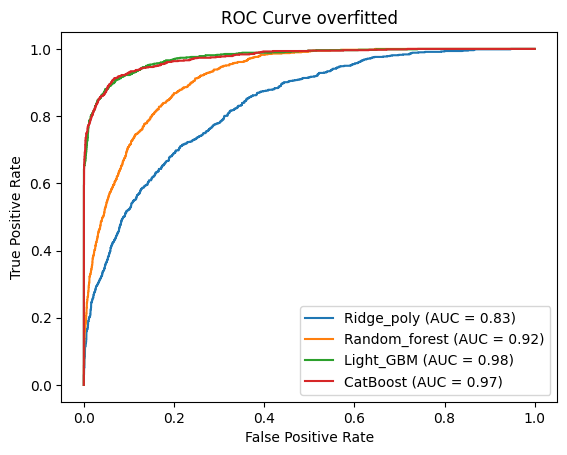

In [106]:
# посмотрим кривые AUC при обучении и тесте на всей обучающей выборке
best_models_overfitted = auc_plot_full(models, X_train, y_train);

100%|██████████| 4/4 [01:44<00:00, 26.23s/it]


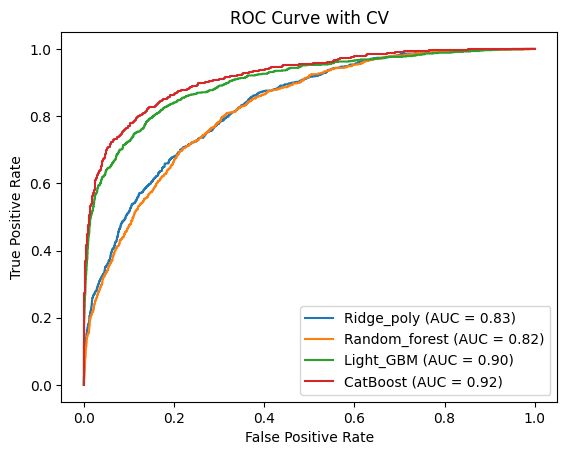

In [107]:
# Построим кривый для кроссвалидации на обучающей выборке
best_models_cv = auc_plot_CV(models, X_train, y_train)

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b></b></u></font>
    <br />
    <font color='4682B4'> Видим, что линейная модель лог.регрессии практически не переобучается: ее метрика сохраняется при обучении-тесте на всей выборке и при использовании кросс-валидации. Случайный лес имеет худшую обощающую способность (хорошо обучается и сильно теряет на тесте).

Модели бустинга имеют лучшие метрики ROC_AUC

   </font>
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b></b></u></font>
    <br />
    <font color='4682B4'> Добавил отдельный расчет метрик с использованием cv_results_` из обученных  `RandomizedSearchCV`

При этом метрика roc_auc и время обучения считалось и записывалось выше- сразу после выполнения `RandomizedSearchCV`
   </font>
</div>

Посмотрим сводку уже полученных данных

In [108]:
model_results

,ROC_AUC_CV,total_time_train_CV,best_model_time_train_CV
Ridge_poly,0.830279,0.730812,0.049251
Random_forest,0.823663,7.087017,0.744941
Light_GBM,0.901219,1.459541,0.080823
CatBoost,0.918783,185.769748,36.650023


Нам необходимо также получить метрики 'accuracy', 'recall', 'precision' для кросс-валидации

In [109]:
# Определение списка метрик
metrics = ['accuracy', 'recall', 'precision']

In [110]:
def calculate_metrics(models, X, y, scoring):
    """
    Вычисляет метрики производительности для best_estimator_
    каждой модели.

    Аргументы:
    - models: список имен моделей для оценки
    - X: признаки для обучения моделей
    - y: целевая переменная
    - scoring: список метрик

    Возвращает:
    - model_results: DataFrame с результатами метрик для каждой модели
    """

    confusion_matrices = {}
    
    for model_name in tqdm(models):
        # Получение объекта RandomSearchCV по имени
        random_search = globals()['random_cv_' + model_name]
        # Получение лучшей модели
        best_model = random_search.best_estimator_

        # Кросс-валидация с расчетом указанных метрик
        cv_results = cross_validate(best_model, X, y, scoring=metrics, cv=CV)

        # Вычисление метрик производительности
#         cv_results = random_search.cv_results_
        for metric in scoring:
            scores = cv_results[f'test_{metric}']
            metric_value = np.mean(scores)
            model_results.loc[model_name, metric] = metric_value



    return model_results

In [111]:
model_results = calculate_metrics(models,X_train, y_train, metrics)

100%|██████████| 4/4 [01:22<00:00, 20.67s/it]


Посмотрим итоговую сводку по метрикам моделей

In [112]:
model_results

,ROC_AUC_CV,total_time_train_CV,best_model_time_train_CV,accuracy,recall,precision
Ridge_poly,0.830279,0.730812,0.049251,0.858387,0.072344,0.887775
Random_forest,0.823663,7.087017,0.744941,0.747632,0.727771,0.342295
Light_GBM,0.901219,1.459541,0.080823,0.911207,0.502564,0.852440
CatBoost,0.918783,185.769748,36.650023,0.914049,0.499543,0.881976


Исходя из данной таблицы результатов, можно сделать следующие выводы:

  - Показатель ROC AUC является важной метрикой для оценки качества моделей. В данном случае, модель CatBoost показывает наивысший показатель ROC AUC, что может указывать на хорошую способность модели разделять классы.

  - Время обучения на кросс-валидации (time_train_CV) варьируется в значительной степени между моделями. Модель Light GBM имеет самое низкое время обучения, в то время как модель CatBoost требует наибольшего времени.

  - Модель CatBoost показывает высокую точность (accuracy), что указывает на способность модели правильно классифицировать большую долю данных.

  - Показатель полноты (recall) отражает способность модели правильно идентифицировать положительный класс. Модель CatBoost имеет показатель полноты (0.49), что уступает случайному лесу.

  - Показатель точности (precision) отражает способность модели избегать ложноположительных результатов. Модель CatBoost имеет высокий показатель точности (0.880), что означает, что она способна минимизировать число ложноположительных предсказаний.

Таким образом, модель CatBoost демонстрирует лучшие результаты по нескольким метрикам, включая ROC AUC, точность, полноту и точность, хотя время обучения у нее также является наибольшим среди рассмотренных моделей.

Для прогноза будем использовать модель CatBoost

### Объяснение модели

In [113]:
feature_importance = pd.Series(random_cv_CatBoost.best_estimator_['model'].feature_importances_,
                               index=combined_features)

In [114]:
feature_importance = (feature_importance/feature_importance.max()).sort_values(ascending=False)

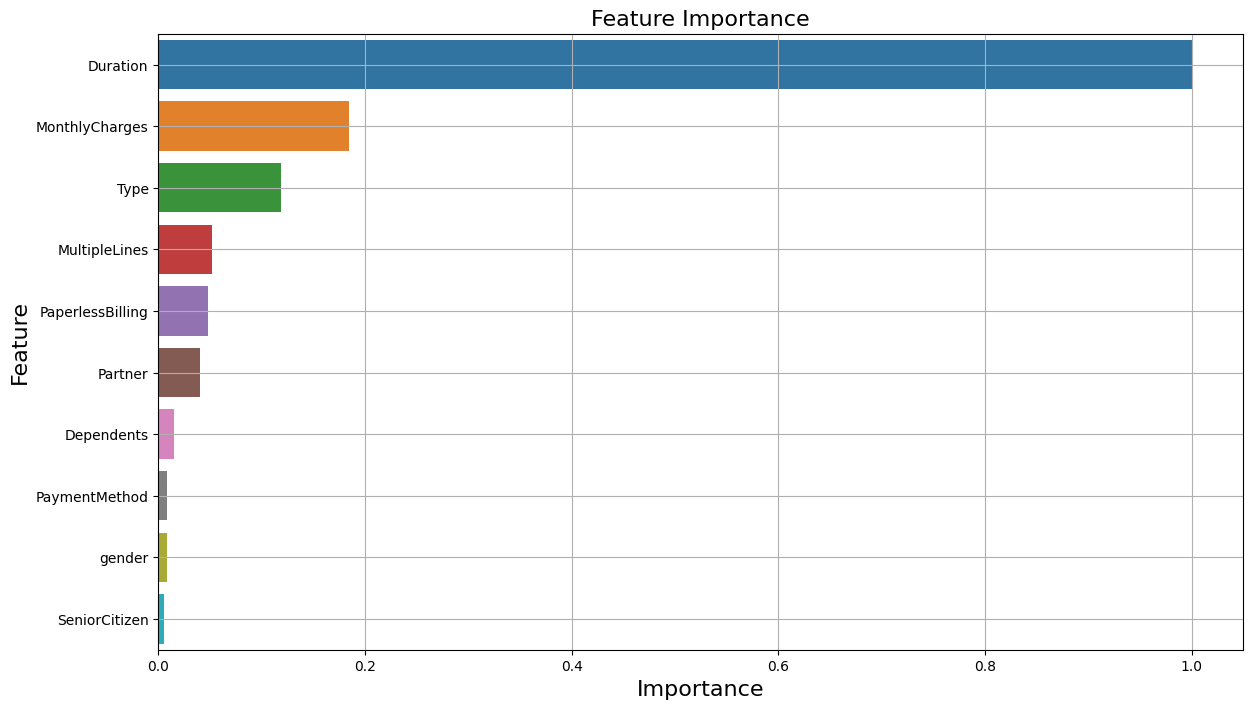

In [115]:
plt.figure(figsize=(14,8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.grid()
# Сохранение графика в файл
# plt.savefig('feature_importance_plot.png')
plt.show()


### Используем библиотеку SHAP

In [116]:
explainer = shap.Explainer(random_cv_CatBoost.best_estimator_['model'])

Поскольку модель выдает трансформированные имена полей - в виде их индексов, преобразуем названия полей, для того, чтобы explainer смог их прочитать

In [117]:
fields = list(combined_features)
# Переупорядочите столбцы в X_train
X_train_ordered = X_train.reindex(columns=fields)
# Сформируйте словарь для переименования полей категориальных признаков
rename_dict = {old_name: str(cat_indices[i]) for i, old_name in enumerate(cat_features)}
# Переименуйте поля в X_train_ordered
X_train_ordered.rename(columns=rename_dict, inplace=True)
# X_train_ordered

In [118]:
shap_values_train = explainer(X_train_ordered)

Построим диаграмму того, какие признаки, в целом, являются наиболее важными для прогнозов, выдаваемых моделью

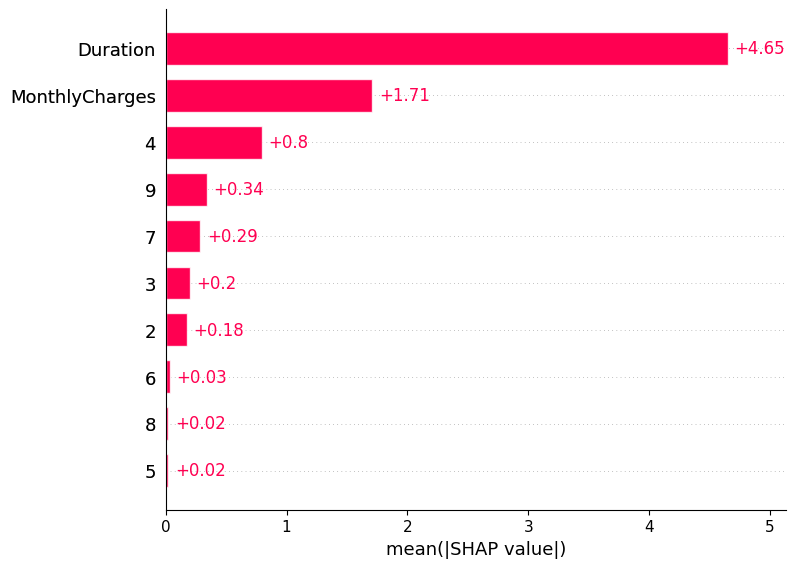

<Figure size 640x480 with 0 Axes>

In [119]:
shap.plots.bar(shap_values_train);
plt.savefig('shap_values_plot.png')
# Отобразите график
plt.show();

In [120]:
pd.DataFrame(combined_features,index=X_train_ordered.columns).transpose()

,Duration,MonthlyCharges,2,3,4,5,6,7,8,9
0,Duration,MonthlyCharges,Type,PaymentMethod,PaperlessBilling,gender,SeniorCitizen,Partner,Dependents,MultipleLines


Впереди с отрывом признак дюрации контракта. Далее в топ 3 по важности- месячные платежи и 4-признак безмумажного выставления счетов

Посмотрим график взаимоотношений между признаками и прогнозами модели

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


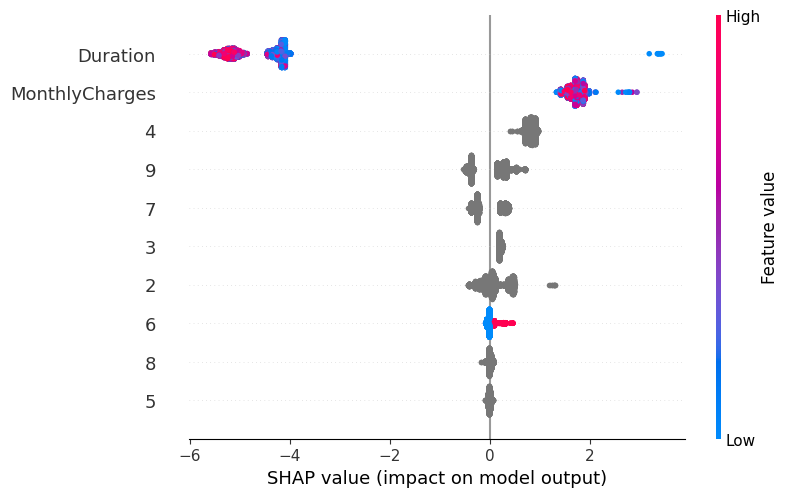

In [121]:
shap.plots.beeswarm(shap_values_train);

Для дюрации можно говорить об обратной зависимости между значимостью признака и его значением.

Посмотрим также диаграмму зависимости между отдельными значениями признаков и их SHAP‑значениями

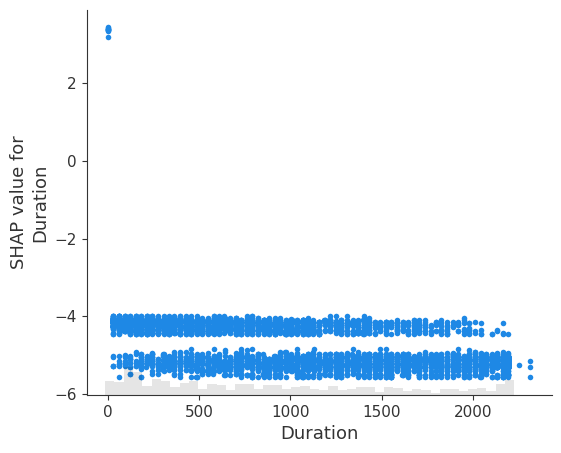

In [122]:
# Получите значения SHAP для признака "Duration"
shap.plots.scatter(shap_values_train[:,"Duration"])


Видим что есть выброс значений значимости на околонулевой дюрации.

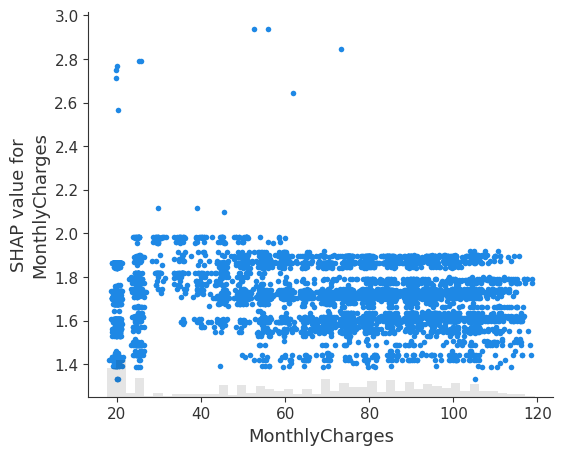

In [123]:
shap.plots.scatter(shap_values_train[:,"MonthlyCharges"])

На данном графике нелзя однозначно сделать вывод о зависимости значимости признака ежемесячных платежей от их размера.

### Тестирование моделей

Создадим копию лучшего оценщика и запустим пайплайн обучения

In [124]:
best_CatBoost = random_cv_CatBoost.best_estimator_

In [125]:
best_CatBoost.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Duration',
                                                   'MonthlyCharges'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000015A4BE26050>)])

Выведем метрику ROC_AUC и Accuracy

In [126]:
roc_auc_score(y_test, best_CatBoost.predict_proba(X_test)[:,1])

0.9251178204240178

In [127]:
accuracy_score(y_test, best_CatBoost.predict(X_test))

0.9244747302668939

Видим, что значение метрик на тестовой выборке соответствует значениям, полученным при кроссвалидации. Еще раз убедились, что обобщающая способность модели высокая.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>__</b></u></font>
    <br />
    <font color='4682B4'> Интерпритация Accuracy:
        
    Accuracy является метрикой, которая измеряет общую точность модели путем сравнения правильно классифицированных наблюдений (уход клиентов) с общим числом наблюдений в тестовом наборе данных. В данном случае, значение 0.9347 означает, что модель правильно предсказала уход клиента в примерно 93.47% случаев на тестовой выборке. Соответственно, для примерно 6,5% фактически ушедших клиентов модель не смогла спрогнозировать их уход.
        
Также учитывая дисбаланс классов можно говорить, что применительно ко всей клиентской базе, модель правильно определяет 14,61% (0.935*0.1563) из всех клиентов, которые уйдут, и не выявляет 1% уходящих клиентов.
   </font>
</div>

Проанализируем матрицу ошибок

In [128]:
# Вычисление матрицы несоответствий
confusion_matrices = {}
y_pred = best_CatBoost.predict(X_test)
confusion_matrices['CatBoost'] = confusion_matrix(y_test, y_pred)

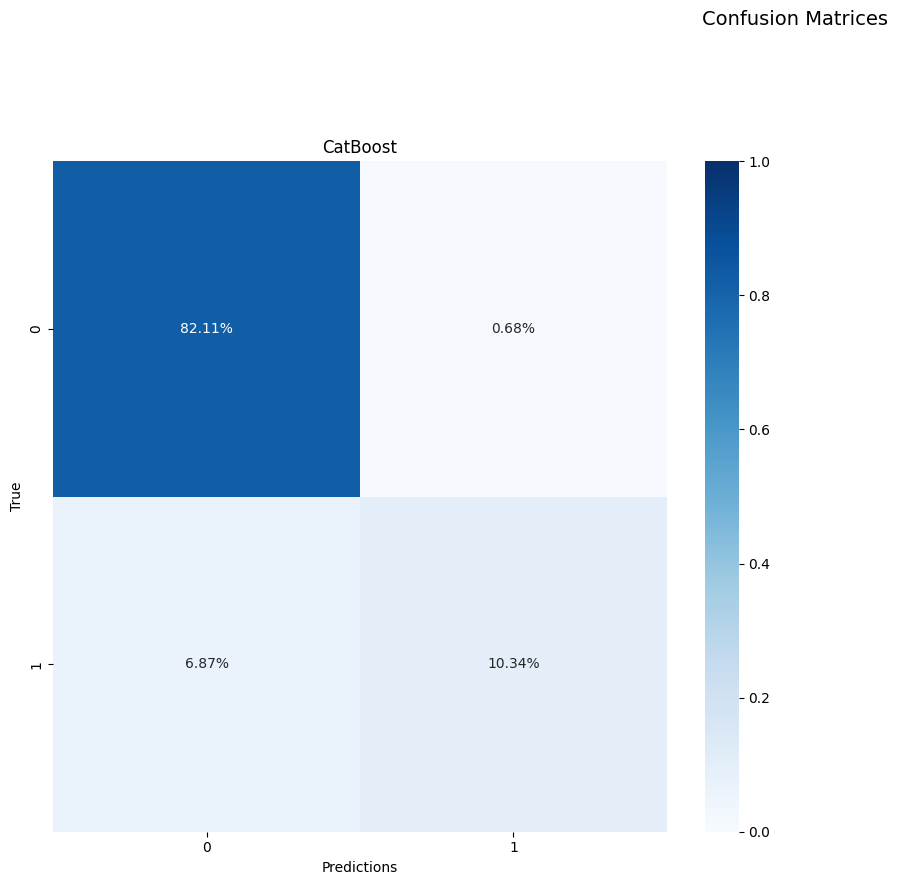

In [129]:
# Определение количества подграфиков
num_subplots = len(confusion_matrices)
num_rows = math.ceil(num_subplots / 2)

# Создание сетки для подграфиков
fig, axes = plt.subplots(num_rows, 2, figsize=(16, 8*num_rows))
axes = axes.flatten()

# Построение тепловых карт для каждой матрицы несоответствий
for i, (name, matrix) in enumerate(confusion_matrices.items()):
    # Вычисление долей в матрице несоответствий
    total = matrix.sum()
    matrix_percent = matrix / total

    # Построение тепловой карты с долями
    sns.heatmap(pd.DataFrame(matrix_percent), annot=True, fmt=".2%", cmap='Blues', vmin=0, vmax=1, ax=axes[i])
    axes[i].set(title=name, xlabel='Predictions', ylabel='True')

# Удаление пустых подграфиков, если их число не кратно 2
if num_subplots % 2 != 0:
    fig.delaxes(axes[-1])

plt.suptitle('Confusion Matrices', fontsize=14, y=1.1)
plt.tight_layout()
plt.show()

In [130]:
confusion_matrices

{'CatBoost': array([[1446,   12],
        [ 121,  182]], dtype=int64)}

   - Верно классифицированы отрицательные случаи (неуход клиента): 1446 (True Negatives).
   - Неверно классифицированы положительные случаи (уход клиента) как отрицательные: 12 (False Negatives).
   - Неверно классифицированы отрицательные случаи как положительные: 121 (False Positives).
   - Верно классифицированы положительные случаи (уход клиента): 182 (True Positives).

Из этой матрицы ошибок и информации о несбалансированности классов можно сделать следующие выводы:

  - Модель CatBoost показывает хороший результат в определении неухода клиента (отрицательные случаи), что подтверждается высоким количеством верно классифицированных отрицательных случаев (True Negatives).

  - Учитывая несбалансированность классов и факт того, что ушедшие клиенты составляют всего 15,63%, количество неверно классифицированных положительных случаев (False Negatives) равное 12 является важным. В данном случае, модель пропустила 12 ушедших клиента, что может быть нежелательным, особенно если сохранение клиентов имеет высокую важность.

  - Количество ложноположительных случаев (False Positives) равное 121 указывает на то, что модель классифицирует некоторые отрицательные случаи как положительные. Это может привести к излишней затрате ресурсов на удержание клиентов, которые фактически не собираются уходить.

Учитывая несбалансированность классов, модель CatBoost обладает некоторым потенциалом для улучшения в определении ушедших клиентов (положительных случаев), а также в сокращении ложноположительных предсказаний. Может потребоваться настройка пороговых значений вероятности классов или использование методов для балансировки классов, чтобы достичь лучшего баланса между полнотой и точностью модели.

## Вывод

В ходе проведенной работы был выполнен анализ данных и построены модели для прогнозирования оттока клиентов. Можно сформулировать следующие ключевые выводы:

   Время пользования услугами оказывает существенное влияние на решение клиента об уходе или остающемся. Большинство ушедших клиентов покидают компанию в первые месяцы. Это указывает на важность принятия мер для удержания клиентов в начальный период использования услуг.

   Цена (ежемесячный платеж) является значимым фактором при выборе услуг. Клиенты, ориентированные на низкие стоимости и экономичные варианты, склонны менять провайдера.

   Длительность контракта, тип оплаты и наличие партнера также оказывают влияние на решение клиента об уходе или остающемся. Постоянные клиенты имеют более долгую длительность контракта и часто предпочитают автоматическое списание средств. Это свидетельствует о важности создания программ лояльности для удержания клиентов.

   Клиенты, подключающие дополнительные услуги (интернет, телефония, телевидение), склонны оставаться дольше. Это указывает на необходимость акцентирования внимания на дополнительных услугах и предложении пакетных предложений, которые повысят лояльность клиентов.

   Большая часть ушедших клиентов платила больше, чем клиенты, которые остаются. Это может указывать на недовольство клиентов соотношением цены и предоставляемых услуг.

   Анализ матриц несоответствий показал, что модели 'Light_GBM' и 'CatBoost' демонстрируют лучшие результаты в верном классифицировании объектов оттока. Они имеют более высокие значения верно классифицированных положительных и отрицательных объектов, что указывает на их хорошую обобщающую способность.

   Модели 'Light_GBM' и 'CatBoost' рекомендуется использовать для прогнозирования оттока клиентов, так как они показывают наилучшие результаты в классификации.

## Отчет

### 1) Выполненные шаги
1.1. Подготовка данных:
   В начале работы были изучены таблицы данных и объединены в одну общую таблицу. Для бинарных признаков, в которых возникли пропуски, было решено заполнить пропуски третьей категорией. Для улучшения анализа и построения моделей были удалены признаки дат, а также добавлены новые признаки, такие как целевая метка (факт ухода клиента) и продолжительность пользования услугами.

1.2. Исследовательский анализ:
   Были проведены исследования зависимостей между признаками и целевым признаком (фактом ухода клиента). В результате был обнаружен мультиколлинеарный признак TotalCharges, который был удален для избежания проблем с мультиколлинеарностью. Также была выявлена небалансированность классов, что потребовало учета этого факта при построении моделей.

1.3. Построение и обучение моделей:
   Были построены и обучены несколько моделей с использованием кросс-валидации: полиномиальная ридж лог.регрессия, случайный лес и градиентный бустинг с использованием моделей LGBMClassifier и CatBoostClassifier. После обучения, была выбрана модель CatBoostClassifier, которая была протестирована на тестовой выборке, вычислена метрика AUC-ROC, а также оценены accuracy и склонность модели к предсказанию ложных ответов.

1.4. Выводы:
   Исходя из результатов, были сделаны выводы, что модель CatBoostClassifier показала наилучшие результаты по метрике AUC-ROC и общей точности предсказаний. Модель имеют меньшую склонность к предсказанию ложных ответов и обладают хорошей способностью обобщения. Таким образом, для прогнозирования оттока клиентов рекомендуется использовать CatBoostClassifier.
   
### 2) Анализ соответствия фактической работы запланированным шагам

   Проверка и подготовка данных:
       - Фактически были выполнены все запланированные шаги, включая поиск ошибок и пропусков, оценку статистик численных значений, сравнение датафреймов на пересечение индексов, создание общего датафрейма и определение категориальных полей, а также заполнение пропусков в обобщенной таблице.

   Исследовательский анализ:
      - В ходе работы были исследованы зависимости признаков от целевого признака, а также была проведена проверка сбалансированности классов. Была обнаружена несбалансированность классов, учтена при построении моделей. Также был обнаружен мультиколлинеарный признак и он был удален для избежания проблем с мультиколлинеарностью.

   Построение и обучение моделей:
      - В рамках выполненной работы было построено несколько моделей с использованием кросс-валидации, включая полиномиальную ридж логистическую регрессию, случайный лес, LGBMClassifier и CatBoostClassifier. Модели были обучены и оценены на основе метрик AUC-ROC, accuracy, а также была проведена оценка их склонности к предсказанию ложных ответов.

   Выводы:
      - Выводы, сделанные в ходе фактической работы, соответствуют запланированным шагам. Было определено, что модель CatBoostClassifier показала наилучшие результаты по метрике AUC-ROC и общей точности предсказаний. Также было отмечено, что модель обладает меньшей склонностью к предсказанию ложных ответов и хорошей способностью обобщения. В результате, для прогнозирования оттока клиентов было рекомендовано использовать CatBoostClassifier.

Таким образом, фактическая работа соответствует запланированным шагам, и выполнение каждого шага привело к достижению поставленных целей и выводов на основе проведенного анализа и обучения моделей.


### 3) Рефлексия над сложностями и описание путей их решения
   Основные трудности были технического характера- как правильно сделать пайплайн, который может учесть разнообразные модели, а также - как правильно распаковывать пайплайн для получения воспроизводимых результатов.

### 4) Итоговый спиок признаков (с расшифровкой) для обучения модели, способы их обработки (как кодировали/стандартизировали/преобразовывали)
  - Категориальные признаки:
    - 'Type': Тип услуги (например, интернет, телефон)
    - 'PaymentMethod': Способ оплаты
    - 'PaperlessBilling': Безбумажное выставление счетов
    - 'gender': Пол клиента
    - 'SeniorCitizen': Признак пожилого клиента
    - 'Partner': Наличие партнера
    - 'Dependents': Наличие иждивенцев
    - 'MultipleLines': Наличие нескольких линий

    Обработка: Для обработки категориальных признаков в модели CatBoostClassifier был использован встроенный механизм автоматического кодирования категориальных признаков. Модель сама определяет оптимальный способ кодирования, учитывая особенности каждого признака.

 - Числовые признаки:
     - 'Duration': Продолжительность пользования услугами (в месяцах)
     - 'MonthlyCharges': Ежемесячные платежи клиента

    Обработка: Для числовых признаков 'Duration' и 'MonthlyCharges' была использована стандартизация с помощью StandardScaler из библиотеки scikit-learn. Стандартизация масштабирует значения признаков таким образом, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это позволяет модели работать с признаками одного порядка величины и улучшает качество обучения.

Таким образом, категориальные признаки были автоматически закодированы моделью CatBoostClassifier, а числовые признаки 'Duration' и 'MonthlyCharges' были стандартизированы с использованием StandardScaler перед подачей на вход модели. Это обеспечивает правильную обработку и учет различных типов признаков при обучении модели.

### 5) Краткое описание предобработки данных (проблема- что делали)

  - Объединение таблиц: Были объединены различные таблицы данных в одну общую таблицу, чтобы иметь единое пространство признаков для анализа и обучения модели.

  - Обработка пропусков: Была проверена наличие пропусков в данных. Для категориальных признаков с пропусками было решено заполнить пропуски третьей категорией, чтобы сохранить информацию о наличии отсутствующих данных. Признаки дат были удалены для упрощения анализа и обучения модели.

  - Обработка мультиколлинеарности: В ходе исследовательского анализа была обнаружена мультиколлинеарность в признаках `["InternetService", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"] `"TotalCharges"`. Для предотвращения проблем с мультиколлинеарностью и улучшения качества модели признаки были удалены из рассмотрения.

  - Кодирование категориальных признаков: Категориальные признаки, такие как тип услуги, способ оплаты, наличие партнера и другие, были автоматически закодированы с использованием встроенного механизма кодирования категориальных признаков в модели CatBoostClassifier. Это позволяет модели корректно работать с категориальными данными без необходимости явного кодирования признаков.

  - Стандартизация числовых признаков: Числовые признаки 'Duration' и 'MonthlyCharges' были стандартизированы с использованием StandardScaler из библиотеки scikit-learn. Стандартизация помогает привести значения признаков к одному масштабу и облегчает обучение модели.

Таким образом, предобработка данных включала объединение таблиц, обработку пропусков, удаление мультиколлинеарного признака, кодирование категориальных признаков и стандартизацию числовых признаков. Все эти шаги были выполнены для обеспечения корректного и эффективного обучения модели CatBoostClassifier на предоставленных данных.

### 6) Сводная таблица исследованных моделей и их метрика на кросс-валидации

| Model          | ROC_AUC_CV | time_train_CV | accuracy  | recall    | precision  |
|----------------|------------|---------------|-----------|-----------|------------|
| Ridge_poly     | 0.830279   | 0.640249      | 0.858387  | 0.072344  | 0.887775   |
| Random_forest  | 0.823663   | 6.657835      | 0.747632  | 0.727771  | 0.342295   |
| Light_GBM      | 0.901219   | 1.521750      | 0.911207  | 0.502564  | 0.852440   |
| CatBoost       | 0.918783   | 170.813265    | 0.914049  | 0.499543  | 0.881976   |

### 7) Лучшая модель
   - Модель:  CatBoostClassifier
   - Параметры:  `max_depth= 3, 'learning_rate = 0.1` остальные параметры - по умолчанию
   - Метрика на кросс-валидации `ROC_AUC` : 0.908
   - Метрика на кросс-валидации `accuracy`: 0.935

### 8) Итоговая метрика на test (ROC_AUS и  Accuracy)
   - Метрика на тесте `ROC_AUC` : 0.925
   - Метрика на тесте `accuracy`: 0.924

### 9) Матрица ошибок:
|           | Predicted 0 | Predicted 1 |
|-----------|-------------|-------------|
| Actual 0  | 1446        | 12           |
| Actual 1  | 121         | 182         |


  - Модель CatBoost показывает хороший результат в определении неухода клиента (отрицательные случаи), что подтверждается высоким количеством верно классифицированных отрицательных случаев (True Negatives) равным 1446.

  - Учитывая несбалансированность классов и факт того, что ушедшие клиенты составляют всего 15,63%, количество неверно классифицированных положительных случаев (False Negatives) равное 12 является важным. В данном случае, модель пропустила 12 ушедших клиента, что может быть нежелательным, особенно если сохранение клиентов имеет высокую важность.

  - Количество ложноположительных случаев (False Positives) равное 121 указывает на то, что модель классифицирует некоторые отрицательные случаи как положительные. Это может привести к излишней затрате ресурсов на удержание клиентов, которые фактически не собираются уходить.

### 10) Важность признаков
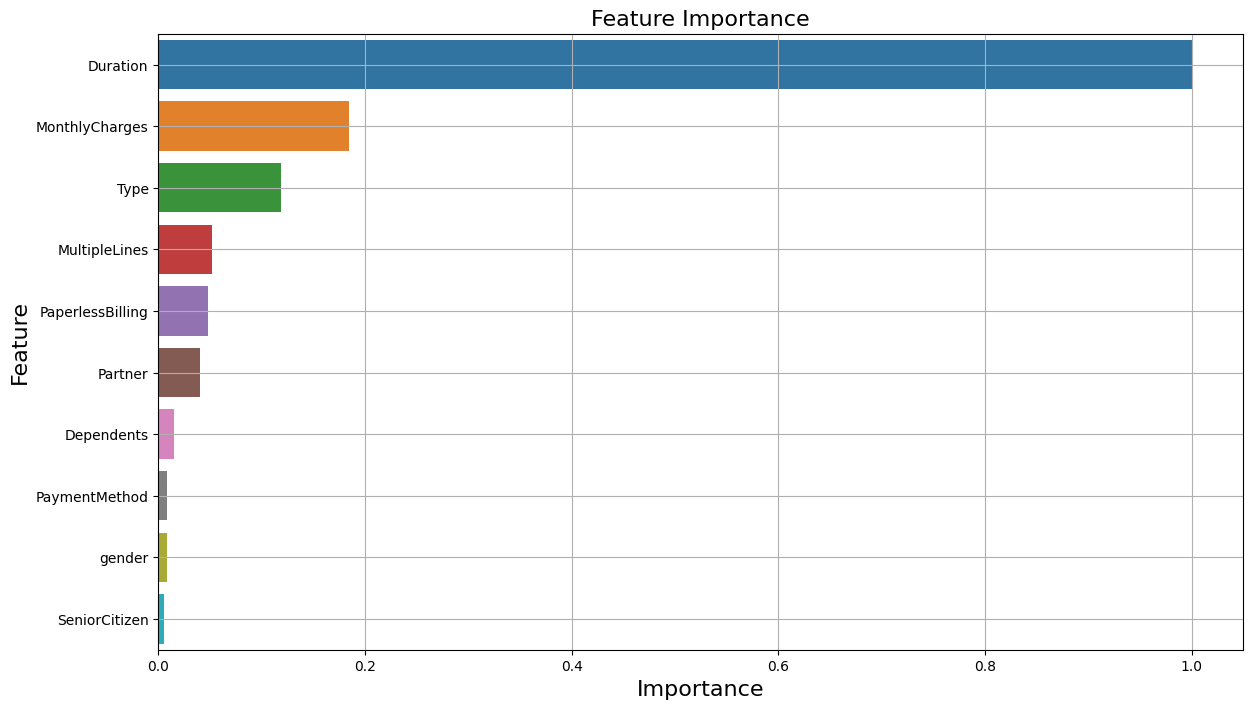
   Немного оважности признаков:
   - Впереди с отрывом признак дюрации контракта
   - Есть выброс значений значимости на околонулевой дюрации..
   - Отсутствует ярковыраженная прямая зависимость значимости признака ежемесячных платежей от их размера
